In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Crypto/test_2/BinanceCoin/BNB-USD.csv', date_parser = True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-30,16.263498,16.370699,15.539147,15.715951,15.715951,213428131
1,2019-12-01,15.743181,15.743181,15.054234,15.496336,15.496336,203268417
2,2019-12-02,15.509364,15.707174,15.152545,15.191858,15.191858,200809249
3,2019-12-03,15.191858,15.553175,15.048669,15.309556,15.309556,219927266
4,2019-12-04,15.348430,15.690587,15.009685,15.279978,15.279978,237605471
...,...,...,...,...,...,...,...
1092,2022-11-26,300.571747,316.962128,300.389465,311.388458,311.388458,1221554861
1093,2022-11-27,311.372040,316.219879,307.156372,307.429291,307.429291,793779029
1094,2022-11-28,307.399567,309.096100,289.493683,293.527252,293.527252,1154829072
1095,2022-11-29,293.491821,304.822815,289.763641,295.498169,295.498169,986451640


# **Data Pre-processing**

In [4]:
#Replace None or Null values with forward filling technique using fillna function.

data = data.fillna(method = 'ffill')

In [5]:
#Convert Date column into Datatime format

data['Date'] = pd.to_datetime(data.Date)

# **Data Visualization**

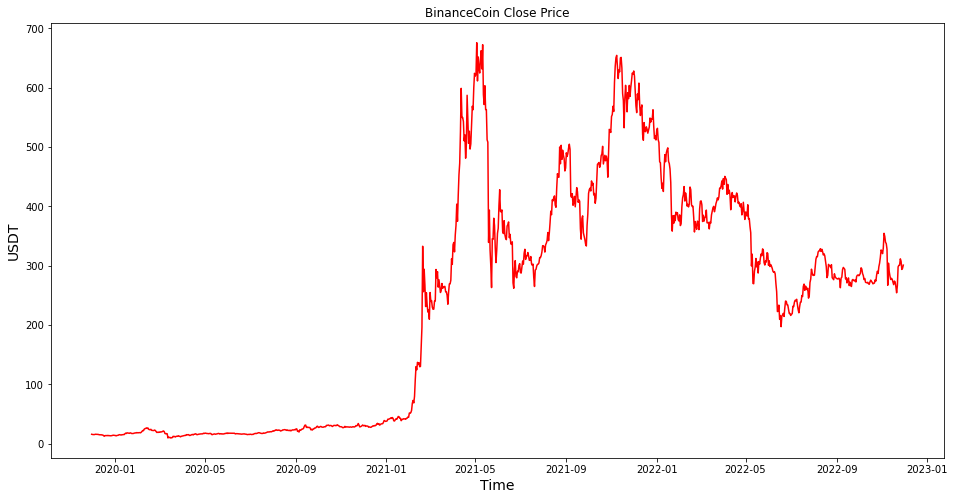

In [6]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.plot(data['Date'], data['Close'], color="red")
plt.title('BinanceCoin Close Price')
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

# **Data Spliting**

In [7]:
data_training = data[data['Date']< '2022-03-30'].copy()
data_training

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-30,16.263498,16.370699,15.539147,15.715951,15.715951,213428131
1,2019-12-01,15.743181,15.743181,15.054234,15.496336,15.496336,203268417
2,2019-12-02,15.509364,15.707174,15.152545,15.191858,15.191858,200809249
3,2019-12-03,15.191858,15.553175,15.048669,15.309556,15.309556,219927266
4,2019-12-04,15.348430,15.690587,15.009685,15.279978,15.279978,237605471
...,...,...,...,...,...,...,...
846,2022-03-25,414.148254,421.153717,406.296051,410.811157,410.811157,1678265707
847,2022-03-26,410.816254,416.317535,407.981262,415.919800,415.919800,1082240527
848,2022-03-27,415.931366,431.025574,412.382904,430.503265,430.503265,1499505093
849,2022-03-28,430.546814,440.728394,428.565216,430.390869,430.390869,2128699500


In [8]:
data_test = data[data['Date']> '2022-03-30'].copy()
data_test

,Date,Open,High,Low,Close,Adj Close,Volume
852,2022-03-31,442.658875,451.961090,424.950287,428.916107,428.916107,2632534284
853,2022-04-01,429.124023,446.796539,414.749390,446.604279,446.604279,2718206274
854,2022-04-02,446.844208,453.558472,436.776703,436.955353,436.955353,2272901729
855,2022-04-03,436.865814,455.228455,432.821716,450.348877,450.348877,2128734028
856,2022-04-04,450.264557,450.432617,434.178009,447.524933,447.524933,2248856403
...,...,...,...,...,...,...,...
1092,2022-11-26,300.571747,316.962128,300.389465,311.388458,311.388458,1221554861
1093,2022-11-27,311.372040,316.219879,307.156372,307.429291,307.429291,793779029
1094,2022-11-28,307.399567,309.096100,289.493683,293.527252,293.527252,1154829072
1095,2022-11-29,293.491821,304.822815,289.763641,295.498169,295.498169,986451640


# **Feature Engineering**

In [9]:
#feature selection
training_data = data_training.drop(['Date', 'Adj Close'], axis = 1)
training_data.head()

,Open,High,Low,Close,Volume
0,16.263498,16.370699,15.539147,15.715951,213428131
1,15.743181,15.743181,15.054234,15.496336,203268417
2,15.509364,15.707174,15.152545,15.191858,200809249
3,15.191858,15.553175,15.048669,15.309556,219927266
4,15.348430,15.690587,15.009685,15.279978,237605471


In [10]:
#Normalizing training_data
scaler=MinMaxScaler()
training_data = scaler.fit_transform(training_data)
print(training_data.shape)

(851, 5)


In [11]:
# we keep the training set as 70% and 30% testing set

training_size=int(len(training_data)*0.70)
test_size=len(training_data)-training_size
train_data,test_data=training_data[0:training_size],training_data[training_size:len(training_data)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (595, 5)
test_data:  (256, 5)


In [12]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (564, 30)
y_train:  (564,)
X_test:  (225, 30)
y_test (225,)


In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (564, 30, 1)
X_test:  (225, 30, 1)


# Model Building

In [15]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape=(None,1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test,y_test),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
18/18 [==============================] - 6s 121ms/step - loss: 0.0202 - val_loss: 0.0133
Epoch 2/50
18/18 [==============================] - 1s 66ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 3/50
18/18 [==============================] - 1s 69ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 4/50
18/18 [==============================] - 1s 67ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 5/50
18/18 [==============================] - 1s 66ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 6/50
18/18 [==============================] - 1s 65ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 7/50
18/18 [==============================] - 1s 64ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 8/50
18/18 [==============================] - 1s 64ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 9/50
18/18 [==============================] - 1s 65ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 10/50
18/18 [==============================] - 1s 65ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 11

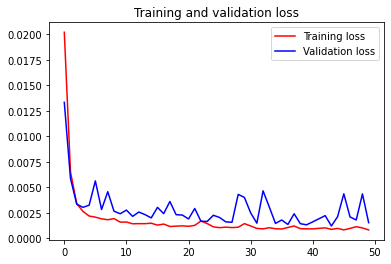

<Figure size 432x288 with 0 Axes>

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

# **Performance Evaluation**

In [18]:
# prediction and check performance metrics

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

print("train_predict: ", train_predict.shape)
print("test_predict: ", test_predict.shape)

8/8 [==============================] - 0s 19ms/step
train_predict:  (564, 1)
test_predict:  (225, 1)


In [19]:
# Transform back to original form

# train_predict = scaler.inverse_transform(train_predict)
# test_predict = scaler.inverse_transform(test_predict)
# original_ytrain = scaler.inverse_transform(y_train) 
# original_ytest = scaler.inverse_transform(y_test)

In [20]:
# Evaluation metrices RMSE, MSE and MAE for train data
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Train data MSE: ", mean_squared_error(y_train,train_predict))
print("Train data MAE: ", mean_absolute_error(y_train,train_predict))
print("Train data R2 score:", r2_score(y_train, train_predict))


Train data RMSE:  0.028970551658096158
Train data MSE:  0.0008392928633744181
Train data MAE:  0.012836684071059243
Train data R2 score: 0.9867816536629428


In [21]:
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))
print("Test data MSE: ", mean_squared_error(y_test,test_predict))
print("Test data MAE: ", mean_absolute_error(y_test,test_predict))
print("Test data R2 score:", r2_score(y_test, test_predict))

Test data RMSE:  0.03918172581507031
Test data MSE:  0.001535207637847347
Test data MAE:  0.03119127648304274
Test data R2 score: 0.8983481700959427


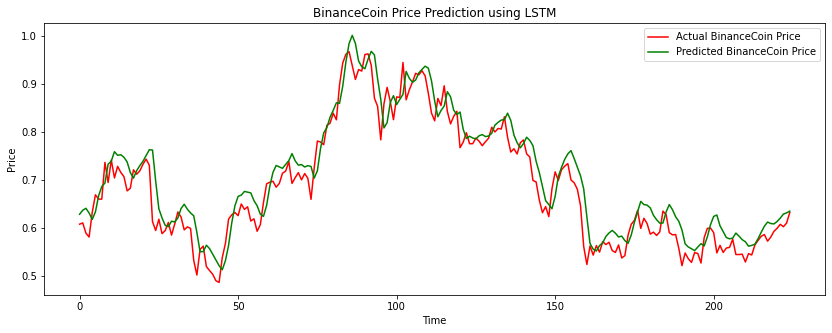

In [22]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Actual BinanceCoin Price')
plt.plot(test_predict, color = 'green', label = 'Predicted BinanceCoin Price')
plt.title('BinanceCoin Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()